In [1]:
# Данные тут
# https://data.seattle.gov/Transportation/Fremont-Bridge-Bicycle-Counter/65db-xm6k
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import datetime

#pip install tscv
import tscv

from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.metrics import r2_score, mean_absolute_percentage_error, root_mean_squared_error

## Добависм время в абсалютном варианте


In [2]:
df = pd.read_csv('Fremont_Bridge_Bicycle_Counter.csv',
                 index_col='Date',
                 parse_dates = True, date_format='mixed').sort_index()
df = df[~df.index.duplicated(keep='last')]
df = df.dropna()
df = df.drop(['Fremont Bridge East Sidewalk','Fremont Bridge West Sidewalk'],axis=1)

data = df.resample('60min').asfreq().interpolate(method='piecewise_polynomial').astype('int')

data.columns = ['Total']
data.head()

,Total
Date,
2012-10-03 00:00:00,13
2012-10-03 01:00:00,10
2012-10-03 02:00:00,2
2012-10-03 03:00:00,5
2012-10-03 04:00:00,7


In [3]:
data_tscv = data['2019-07':'2019-09']

gap_size = 3*24

cv = tscv.GapKFold( n_splits=5, gap_before= 3*23, gap_after=3*23)

X_train, X_test, y_train, y_test = tscv.gap_train_test_split(
                data_tscv.index.to_pydatetime().reshape(-1,1), 
                data_tscv['Total'], 
                test_size = 0.25, 
                gap_size=gap_size)
data_tscv.head(5)

,Total
Date,
2019-07-01 00:00:00,10
2019-07-01 01:00:00,6
2019-07-01 02:00:00,3
2019-07-01 03:00:00,2
2019-07-01 04:00:00,12


In [4]:
def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error", "r2"],
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    r2 = cv_results["test_r2"]
    print(
        f"Mean Absolute Error (MAE):     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error (RMSE): {rmse.mean():.3f} +/- {rmse.std():.3f}\n"
        f"R^2 : {r2.mean():.3f} +/- {r2.std():.3f}"
    )

In [5]:
def transform_time_hour(X):
    """Конвектор datetime  в числовой формат"""
    return pd.DataFrame(X).apply(lambda x: pd.DatetimeIndex(x).hour)

def transform_time(tmp='hour'):
    """Универсальеый конвектор datetime  в числовой формат"""
    """код пишет сам себя :)"""
    return eval('FunctionTransformer(lambda X: pd.DataFrame(X).apply(lambda x: \
                pd.DatetimeIndex(x).'+tmp+'))')


In [6]:
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))
def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

In [7]:
def transform_index(tmp):
    return pd.DataFrame(tmp).map(lambda x: datetime.datetime.timestamp(x))#// 10**10

(-1.5, 1.5)

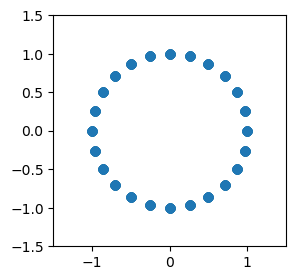

In [8]:

plt.figure(figsize=(3, 3))
sin_df = sin_transformer(24).fit_transform(transform_time_hour(X_train))
cos_df  = cos_transformer(24).fit_transform(transform_time_hour(X_train))
plt.scatter(sin_df, cos_df)
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)

In [9]:
ct = ColumnTransformer(
    [
     ('ind', FunctionTransformer(transform_index),[0]), 
        
     ("hour",  transform_time('hour'),[0]),
     ("week",  transform_time('weekday'),[0]),
     ("month", transform_time('month'),[0])
    ]
).set_output(transform='pandas')

X_train_1 = ct.fit_transform(X_train)
X_train_1.head()

,ind__0,hour__0,week__0,month__0
0,1.561928e+09,0,0,7
1,1.561932e+09,1,0,7
2,1.561936e+09,2,0,7
3,1.561939e+09,3,0,7
4,1.561943e+09,4,0,7


In [10]:
cyclic_cos_sin_transformer = ColumnTransformer(
    transformers=[
        ("month_sin", sin_transformer(12), ["month__0"]),
        ("month_cos", cos_transformer(12), ["month__0"]),
        ("weekday_sin", sin_transformer(7), ["week__0"]),
        ("weekday_cos", cos_transformer(7), ["week__0"]),
        ("hour_sin", sin_transformer(24), ["hour__0"]),
        ("hour_cos", cos_transformer(24), ["hour__0"]),
    ],
    remainder=MinMaxScaler(),
).set_output(transform='pandas')
cyclic_cos_sin_transformer

,transformers,"[('month_sin', ...), ('month_cos', ...), ...]"
,remainder,MinMaxScaler()
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,func,<function sin...t 0x152bf8360>
,inverse_func,None
,validate,False


In [11]:
X_train_2 = cyclic_cos_sin_transformer.fit_transform(X_train_1)
X_train_2.head()

,month_sin__month__0,month_cos__month__0,weekday_sin__week__0,weekday_cos__week__0,hour_sin__hour__0,hour_cos__hour__0,remainder__ind__0
0,-0.5,-0.866025,0.0,1.0,0.000000,1.000000,0.000000
1,-0.5,-0.866025,0.0,1.0,0.258819,0.965926,0.000625
2,-0.5,-0.866025,0.0,1.0,0.500000,0.866025,0.001249
3,-0.5,-0.866025,0.0,1.0,0.707107,0.707107,0.001874
4,-0.5,-0.866025,0.0,1.0,0.866025,0.500000,0.002498


In [12]:
cyclic_cos_sin_linear_pipeline = make_pipeline(
    ct,
    cyclic_cos_sin_transformer,
    RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
)


evaluate(cyclic_cos_sin_linear_pipeline, X = X_train, y = y_train, cv=cv)

cyclic_cos_sin_linear_pipeline.fit(X_train, y_train)

y_train_predict = cyclic_cos_sin_linear_pipeline.predict(X_train)
y_predict = cyclic_cos_sin_linear_pipeline.predict(X_test)
root_mean_squared_error(y_test, y_predict)

Mean Absolute Error (MAE):     30.004 +/- 8.876
Root Mean Squared Error (RMSE): 59.420 +/- 19.276
R^2 : 0.901 +/- 0.065


75.0213965880788

In [13]:
cyclic_cos_sin_linear_pipeline

,steps,"[('columntransformer-1', ...), ('columntransformer-2', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('ind', ...), ('hour', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


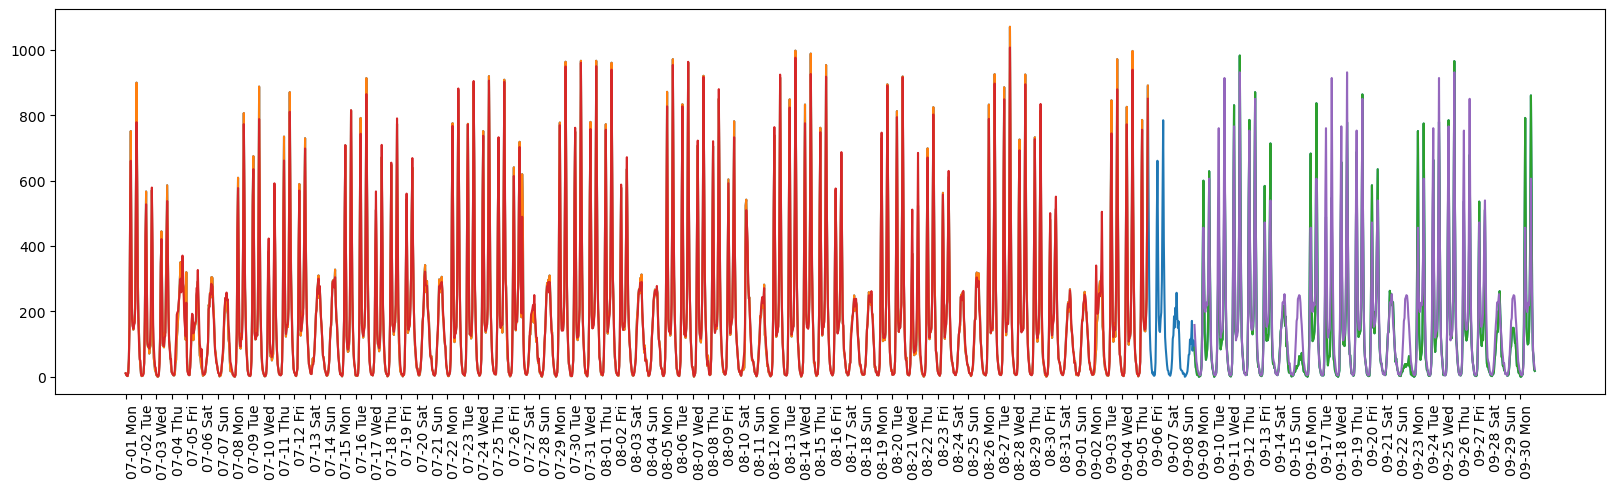

In [14]:
plt.figure(figsize=(20, 5))

xticks = pd.date_range(start = data_tscv.index.min(), end=data_tscv.index.max(),freq='D')
x_range = [data_tscv.index.get_loc(t) for t in xticks]

plt.xticks(x_range, xticks.strftime("%m-%d %a"), rotation=90, ha="left")

# все истина
plt.plot(range(len(data_tscv)), data_tscv.values.reshape(-1), label="all")
# тренировка истина
plt.plot(range(len(X_train)), y_train, label="train")
# тест истина
plt.plot(range(len(X_train)+gap_size,len(X_train)+gap_size+len(X_test)), y_test, label="train");

# тренировка predict
plt.plot(range(len(X_train)), y_train_predict, label="train predict")

# тренировка predict
plt.plot(range(len(X_train)+gap_size,len(X_train)+gap_size+len(X_test)), y_predict, label="predict");